##  Reconstruction Of Images Using RBM on MNIST dataset

* Import the modules

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow import keras
import matplotlib.pyplot as plt

* Declare the class RBM. The __init__ function will build the complete graph, forward and backward pass, and the objective function. 
* We use the TensorFlow built-in optimizer to update the weights and biases

In [0]:

class RBM(object):
    def __init__(self, visible, hidden):
        """
        visible: Number of neurons in visible layer
        hidden: number of neurons in hidden layer
        """
        self._visible = visible
        self._hidden = hidden
                
        
        
        # Create the Computational graph
       
        # Weights and biases
        self._W = tf.Variable(tf.random_normal(shape=(self._visible,self._hidden)))
        self._hidden_bias = tf.Variable(np.zeros(self._hidden).astype(np.float32))  #bias for hidden layer
        self._visible_bias = tf.Variable(np.zeros(self._visible).astype(np.float32))  #bias for Visible layer
            
        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._visible])
                                               
        # Forwards Pass
        _h = tf.nn.sigmoid(tf.matmul(self._X, self._W) + self._hidden_bias)
        self.h = tf.nn.relu(tf.sign(_h - tf.random_uniform(tf.shape(_h))))
                      
            
        #Backward pass
        _v = tf.nn.sigmoid(tf.matmul(self.h, tf.transpose(self._W)) + self._visible_bias)
        self.V = tf.nn.relu(tf.sign(_v - tf.random_uniform(tf.shape(_v))))
                        
                                              
        # Objective Function
        objective = tf.reduce_mean(self.free_energy(self._X)) - tf.reduce_mean(
                              self.free_energy(self.V))
        self._train_op =  tf.train.GradientDescentOptimizer(1e-3).minimize(objective)
        
        # Cross entropy cost
        reconstructed_input = self.one_pass(self._X)
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self._X, logits=reconstructed_input))

            
            
    def set_session(self, session):
        self.session = session
            
                                   
            
    def free_energy(self, V):
        b = tf.reshape(self._visible_bias, (self._visible, 1))
        term_1 = -tf.matmul(V,b)
        term_1 = tf.reshape(term_1, (-1,))
        
        term_2 = -tf.reduce_sum(tf.nn.softplus(tf.matmul(V,self._W) + self._hidden_bias))
        return term_1 + term_2
    
    def one_pass(self, X):
        h = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return tf.matmul(h, tf.transpose(self._W)) + self._visible_bias
    
    def reconstruct(self,X):
        x = tf.nn.sigmoid(self.one_pass(X))
        return self.session.run(x, feed_dict={self._X: X})
     
    def rbm_output(self,X):
        x = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return self.session.run(x, feed_dict={self._X: X})
        
        
    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size
        
        obj = []
        for i in range(epochs):
            np.random.shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._train_op,self.cost ], feed_dict={self._X: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format((i+1),ob, j)) 
                obj.append(ob)
        return obj

* Load the MNIST dataset

In [0]:
(train_X, train_Y), (test_X, test_Y) = keras.datasets.mnist.load_data()

* We train our RBM on the MNIST dataset

In [30]:

X_train = train_X.reshape((train_X.shape[0],784)).astype("float32")
X_test = test_X.reshape((test_X.shape[0],784)).astype("float32")
X_train /= 255
X_test /= 255
_, m = X_train.shape
rbm = RBM(m, 500)
#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    rbm.set_session(sess)
    err = rbm.fit(X_train, epochs=10)
    out = rbm.reconstruct(X_test[0:10000])  # Let us reconstruct Test Data

training epoch 1 batch 0 cost 5.774251937866211
training epoch 1 batch 100 cost 0.2809741795063019
training epoch 1 batch 200 cost 0.2373839020729065
training epoch 1 batch 300 cost 0.20523042976856232
training epoch 1 batch 400 cost 0.19808940589427948
training epoch 1 batch 500 cost 0.1844194382429123
training epoch 2 batch 0 cost 0.18783099949359894
training epoch 2 batch 100 cost 0.1821873039007187
training epoch 2 batch 200 cost 0.16972962021827698
training epoch 2 batch 300 cost 0.1642192006111145
training epoch 2 batch 400 cost 0.1591227948665619
training epoch 2 batch 500 cost 0.15633279085159302
training epoch 3 batch 0 cost 0.16452372074127197
training epoch 3 batch 100 cost 0.15768206119537354
training epoch 3 batch 200 cost 0.15080422163009644
training epoch 3 batch 300 cost 0.15805521607398987
training epoch 3 batch 400 cost 0.1468885987997055
training epoch 3 batch 500 cost 0.15841680765151978
training epoch 4 batch 0 cost 0.14326481521129608
training epoch 4 batch 100 co

Text(0, 0.5, 'cost')

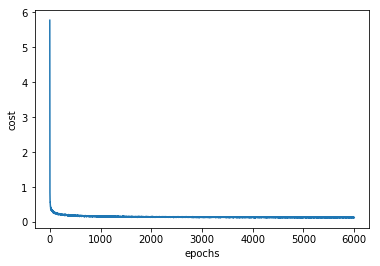

In [31]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')

* We can see the original and reconstructed MNIST images by using a small helper plotting code

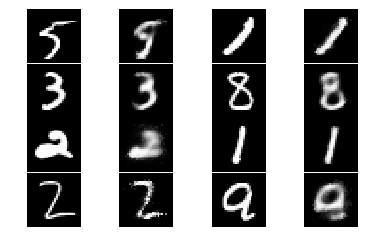

In [32]:
# Plotting original and reconstructed images


def draw_sample(rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols//2):
        n=np.random.randint(0,10000)
        plt.subplot(rows, cols, i*2+1)
        img = X_test[n+i].reshape(28,28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.subplot(rows, cols, i*2+2 )
        img2 = out[n+i].reshape(28,28)
        plt.imshow(img2, cmap='gray')
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
      
draw_sample()